# LISA FD response applied to PhenomD amp/phase waveforms

Sylvain Marsat | 2017-08-21

## Loading

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt

In [ ]:
import sys
sys.path.append('../IMRPhenomD/')

In [3]:
from pyFDresponse import *

## Definitions

### Plotting

In [4]:
# Color palette stolen from seaborn package (deep, with reshuffled ordering)
# SEABORN_PALETTES = dict(
#     deep=["#4C72B0", "#55A868", "#C44E52",
#           "#8172B2", "#CCB974", "#64B5CD"],
#     muted=["#4878CF", "#6ACC65", "#D65F5F",
#            "#B47CC7", "#C4AD66", "#77BEDB"],
#     pastel=["#92C6FF", "#97F0AA", "#FF9F9A",
#             "#D0BBFF", "#FFFEA3", "#B0E0E6"],
#     bright=["#003FFF", "#03ED3A", "#E8000B",
#             "#8A2BE2", "#FFC400", "#00D7FF"],
#     dark=["#001C7F", "#017517", "#8C0900",
#           "#7600A1", "#B8860B", "#006374"],
#     colorblind=["#0072B2", "#009E73", "#D55E00",
#                 "#CC79A7", "#F0E442", "#56B4E9"]
#)
palette = ["#4C72B0", "#C44E52", "#CCB974", "#55A868", "#8172B2", "#64B5CD"]

In [5]:
def plot_wf_ampphase(wf):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    f, amp, phase = wf
    ax1.plot(f, amp, color=palette[0])
    ax1.set_xlim(min(f), max(f))
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid()
    ax2.plot(f, phase, color=palette[0])
    ax2.set_xlim(min(f), max(f))
    ax2.set_xscale('log')
    ax2.grid()
    plt.show()

In [6]:
def plot_wf_tdi_all(wf, scalebyf2=False):
    fig, ax = plt.subplots(3, 3, figsize=(16,12))
    f, amp, phase, phaseRdelay, transferL1, transferL2, transferL3, TDI1, TDI2, TDI3, TDItag = wf['freq'], wf['amp'], wf['phase'], wf['phaseRdelay'], wf['transferL1'], wf['transferL2'], wf['transferL3'], wf['TDI1'], wf['TDI2'], wf['TDI3'], wf['TDItag']
    # Common settings
    for i in range(3):
        for j in range(3):
            ax[i][j].set_xlim(min(f), max(f))
            ax[i][j].set_xscale('log')
            ax[i][j].set_xlabel(r'f (Hz)')
            ax[i][j].grid()
    # Amp
    ax[0][0].plot(f, amp, color=palette[0])
    ax[0][0].set_yscale('log')
    ax[0][0].set_ylabel(r'$A_{22}$')
    ax[0][0].set_title(r'Amplitude')
    # Phase
    ax[0][1].plot(f, phase, color=palette[0])
    ax[0][1].set_xscale('log')
    ax[0][1].set_ylabel(r'$\Phi_{22}$')
    ax[0][1].set_title(r'Phase')
    # Orbital delay phase
    ax[0][2].plot(f, phaseRdelay, color=palette[0])
    ax[0][2].set_xscale('log')
    ax[0][2].axhline(0, color='k')
    ax[0][2].set_ylabel(r'$\Phi_{d_0}$')
    ax[0][2].set_title(r'Orbital delay phase')
    # TDI and transfer
    transL = {}
    if scalebyf2:
        fstar = C_SI/L_SI
        transL[1], transL[2], transL[3] = transferL1*(fstar/f)**2, transferL2*(fstar/f)**2, transferL3*(fstar/f)**2
    else:
        transL[1], transL[2], transL[3] = transferL1, transferL2, transferL3
    tdi = {}
    tdi[1], tdi[2], tdi[3] = TDI1, TDI2, TDI3
    # Labels
    tdilabel = {}
    if TDItag=='TDIXYZ':
        tdilabel[1] = 'X'
        tdilabel[2] = 'Y'
        tdilabel[3] = 'Z'
    elif TDItag=='TDIAET':
        tdilabel[1] = 'A'
        tdilabel[2] = 'E'
        tdilabel[3] = 'T'
    else:
        raise ValueError("Error in plot_wf_tdi: TDItag not recognized.")
    ylabeltrans = {}; titletrans = {}; ylabeltdi = {}; titletdi = {};
    for i in range(1,4):
        if scalebyf2:
            ylabeltrans[i] = r'$(f_{*}/f)^2\mathcal{T}^L_'+tdilabel[i]+'$'
        else:
            ylabeltrans[i] = r'$\mathcal{T}^L_'+tdilabel[i]+'$'
        titletrans[i] = r'Transfer '+tdilabel[i]+' Re/Im'
        ylabeltdi[i] = r'$\mathrm{TDI}_'+tdilabel[i]+'$'
        titletdi[i] = r'TDI '+tdilabel[i]+' Re/Im'
    # Plot transfer
    for i in range(1,4):
        ax[1][i-1].plot(f, np.real(transL[i]), color=palette[0])
        ax[1][i-1].plot(f, np.imag(transL[i]), color=palette[1])
        ax[1][i-1].axhline(0, color='k')
        ax[1][i-1].set_ylabel(ylabeltrans[i])
        ax[1][i-1].set_title(titletrans[i])
    # Plot TDI
    for i in range(1,4):
        ax[2][i-1].plot(f, np.real(tdi[i]), color=palette[0])
        ax[2][i-1].plot(f, np.imag(tdi[i]), color=palette[1])
        ax[2][i-1].axhline(0, color='k')
        ax[2][i-1].set_ylabel(ylabeltdi[i])
        ax[2][i-1].set_title(titletdi[i])
    plt.tight_layout()
    plt.show()

In [7]:
# Restrict data to an interval according to first column
def restrict_data(data, interval):
    if not interval: # test if interval==[]
        return data
    else:
        # Make an initial guess based on global length - then adjust starting and ending indices
        x = data[:,0]
        n = len(data)
        deltax = (x[-1] - x[0]) / n
        if interval[0] < x[0]:
            ibeg = 0
        else:
            ibeg = min(int((interval[0]-x[0]) / deltax), n-1)
            while ibeg < n and x[ibeg] < interval[0]:
                ibeg += 1
            while ibeg > 0 and x[ibeg-1] > interval[0]:
                ibeg -= 1
        if interval[-1] > x[-1]:
            iend = n-1
        else:
            iend = n-1 - min(int((x[-1] - interval[-1]) / deltax), n-1)
            while iend > 0 and x[iend] > interval[-1]:
                iend -= 1
            while iend < n-1 and x[iend+1] < interval[-1]:
                iend += 1
        return data[ibeg:iend+1]

In [8]:
# Color palette stolen from seaborn package (deep, with reshuffled ordering)
# SEABORN_PALETTES = dict(
#     deep=["#4C72B0", "#55A868", "#C44E52",
#           "#8172B2", "#CCB974", "#64B5CD"],
#     muted=["#4878CF", "#6ACC65", "#D65F5F",
#            "#B47CC7", "#C4AD66", "#77BEDB"],
#     pastel=["#92C6FF", "#97F0AA", "#FF9F9A",
#             "#D0BBFF", "#FFFEA3", "#B0E0E6"],
#     bright=["#003FFF", "#03ED3A", "#E8000B",
#             "#8A2BE2", "#FFC400", "#00D7FF"],
#     dark=["#001C7F", "#017517", "#8C0900",
#           "#7600A1", "#B8860B", "#006374"],
#     colorblind=["#0072B2", "#009E73", "#D55E00",
#                 "#CC79A7", "#F0E442", "#56B4E9"]
#)
palette = ["#4C72B0", "#C44E52", "#CCB974", "#55A868", "#8172B2", "#64B5CD"]
def lplot(ax, *args, **kwargs):
    rangex = kwargs.get('rangex', [])
    rangey = kwargs.get('rangey', [])
    ds = kwargs.get('downsample', 1)
    size = kwargs.get('figsize', (8, 4))
    grid = kwargs.get('grid', True)
    colormap = kwargs.get('colormap', None)
    colormapbounds = kwargs.get('colormapbounds', [0.,1.])
    colors = kwargs.get('colors', None)
    linestyles = kwargs.get('linestyles', None)
    log_xscale = kwargs.get('log_xscale', False)
    log_yscale = kwargs.get('log_yscale', False)
    n = len(args)
    if colors is None: # colors option supersedes colormap
        if colormap is not None:
            colorm = cm.get_cmap(colormap)
            colors = [colorm(x) for x in np.linspace(colormapbounds[0], colormapbounds[1], n)]
        else:
            #defaultcolorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']
            defaultcolorlist = palette
            colors = fold_list(defaultcolorlist, n)
    if linestyles is None:
        linestyles = ['-' for i in range(n)]
    f = plt.figure(0, figsize=size)
    minxvals = np.zeros(n)
    maxxvals = np.zeros(n)
    minyvals = np.zeros(n)
    maxyvals = np.zeros(n)
    avyvals = np.zeros(n)
    for i, x in enumerate(args):
        if type(x[1]) is np.ndarray:
            data = restrict_data(np.array([x[0][::ds], x[1][::ds]]).T, rangex)
            col1, col2 = [0, 1]
        else:
            data = restrict_data(x[0][::ds], rangex)
            col1, col2 = x[1]
        if not log_xscale:
            minxvals[i] = data[0, col1]
        else: # Restrict to the first non-zero value of y - convenient for log-x plots (also always exclude x=0)
            datax = data[:, col1]
            datay = data[:, col2]
            if datax[0]==0.:
                datax = datax[1:]
                datay = datay[1:]
            minxvals[i] = datax[(datay > 0)][0]
        maxxvals[i] = data[-1, col1]
        minyvals[i] = min(data[:, col2])
        maxyvals[i] = max(data[:, col2])
        avyvals[i] = np.average(data[:, col2])
        ax.plot(data[:,col1], data[:,col2], color=colors[i], linestyle=linestyles[i])
    if rangex:
        ax.set_xlim(rangex[0], rangex[1])
    else:
        ax.set_xlim(min(minxvals), max(maxxvals))
    if rangey:
        ax.set_ylim(rangey[0], rangey[1])
    else:
        if log_yscale:
            minyvalplot = max(min(minyvals), 1e-8*np.average(avyvals))
            ax.set_ylim(1./1.5*minyvalplot, 1.5*max(maxyvals))
        else:
            margin = 0.1 * (max(maxyvals) - np.average(avyvals))
            ax.set_ylim(min(minyvals) - margin, max(maxyvals) + margin)
    if log_xscale:
        ax.set_xscale('log')
    if log_yscale:
        ax.set_yscale('log')
    if grid:
        ax.grid()
        
def llogplot(ax, *arg, **kwargs):
    args = (ax,) + arg
    return lplot(*args, log_yscale=True, **kwargs)
def lloglinearplot(ax, *arg, **kwargs):
    args = (ax,) + arg
    return lplot(*args, log_xscale=True, **kwargs)
def lloglogplot(ax, *arg, **kwargs):
    args = (ax,) + arg
    return lplot(*args, log_xscale=True, log_yscale=True, **kwargs)

### Building hp,hc from h22

In [9]:
# Compute hp, hc on input frequency grid by interpolating amp/phase
def ComputehphcFromAmpPhase(wf, freq, iota, phi):
    f, amp, phase = wf
    amp_Int = spline(f, amp)
    phase_Int = spline(f, phase)
    indices = (f[0]<=freq) & (freq<=f[-1])
    factorp = 1/2. * (SpinWeightedSphericalHarmonic(-2, 2, 2, iota, phi) + np.conj(SpinWeightedSphericalHarmonic(-2, 2, -2, iota, phi)))
    factorc = 1j/2. * (SpinWeightedSphericalHarmonic(-2, 2, 2, iota, phi) - np.conj(SpinWeightedSphericalHarmonic(-2, 2, -2, iota, phi)))
    h22tilde = np.zeros_like(freq, dtype=np.complex128)
    h22tilde[indices] = amp_Int(freq[indices]) * np.exp(1j*phase_Int(freq[indices]))
    hptilde = factorp * h22tilde
    hctilde = factorc * h22tilde
    return freq, hptilde, hctilde

In [10]:
# Compute hp, hc on input frequency grid by interpolating amp/phase
def Computeh22FromAmpPhase(wf, freq):
    f, amp, phase = wf
    amp_Int = spline(f, amp)
    phase_Int = spline(f, phase)
    indices = (f[0]<=freq) & (freq<=f[-1])
    h22tilde = np.zeros_like(freq, dtype=np.complex128)
    h22tilde[indices] = amp_Int(freq[indices]) * np.exp(1j*phase_Int(freq[indices]))
    return freq, h22tilde

## PhenomD: compare amp/phase to hplus/hcross

In [26]:
# Some generic values for the orientation parameters
[phi0, fRef, chi1, chi2, dist, inc, lambd, beta, psi] = [1.2, 0., 0.9, -0.8, 100e6, pi/3, 1.7, 1.05, 2.3]

In [27]:
[m1, m2] = [2e6, 1e6]
[m1_SI, m2_SI] = [m1*MSUN_SI, m2*MSUN_SI]
dist_SI = dist*PC_SI
tobs = 4.
[minf, maxf] = [5e-5, 0.2/((m1+m2)*MTSUN_SI)]

In [28]:
wf_Cy = pyIMRPhenomD.IMRPhenomD(phi0, fRef, 2./(tobs*YRSID_SI), m1_SI, m2_SI, chi1, chi2, minf, maxf, dist_SI, inc)
fHz_Cy, hptilde_Cy, hctilde_Cy = wf_Cy.GetWaveform()

In [29]:
fds = logsampling(minf, maxf, num=200)
wf_ampphase = pyIMRPhenomD.IMRPhenomDh22AmpPhase(fds, phi0, 0., m1_SI, m2_SI, chi1, chi2, dist_SI)
wf_ds = wf_ampphase.GetWaveform()

In [30]:
fHz, hptilde, hctilde = ComputehphcFromAmpPhase(wf_ds, fHz_Cy, inc, 0.)

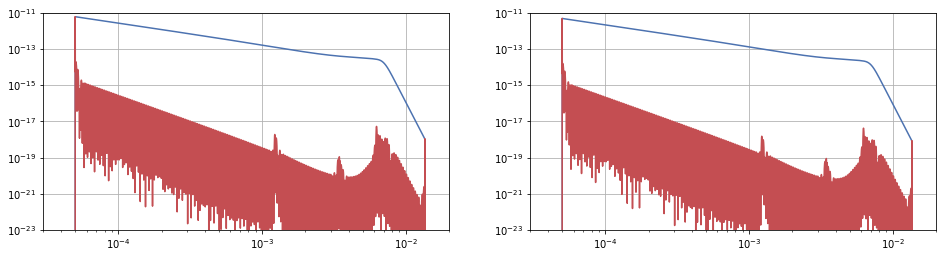

In [31]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=[16,4])
lloglogplot(ax1, [fHz, np.abs(hptilde)], [fHz, np.abs(np.conj(hptilde)-hptilde_Cy)], domain=[4e-5, 2e-2], colors=palette[:2], rangex=[3e-5,2e-2], rangey=[1e-23,1e-11])
lloglogplot(ax2, [fHz, np.abs(hctilde)], [fHz, np.abs(np.conj(hctilde)-hctilde_Cy)], domain=[4e-5, 2e-2], colors=palette[:2], rangex=[3e-5,2e-2], rangey=[1e-23,1e-11])

## LISA FD response: examples

### Common parameters

In [26]:
# Some generic values for the orientation parameters
# 36.6 Gpc corresponds to z=4
[phi0, fRef, chi1, chi2, dist, inc, lambd, beta, psi] = [1.2, 0., 0.9, -0.8, 36.6e3, pi/3, 1.7, 1.05, 2.3]
# So far, the only choice implemented: MLDC trajectories and TDI XYZ
[t0, trajdict, TDItag] = [0., trajdict_MLDC, "TDIXYZ"]
# 4 years of observations, frequency band from 1e-5Hz to 1Hz
[minf, maxf, tobs] = [1e-5, 1., 4.]

### [m1,m2] = [4e8, 2e8] Msol

In [27]:
[m1, m2] = [4e8, 2e8]

In [28]:
wf = GenerateResamplePhenomD(phi0, fRef, m1, m2, chi1, chi2, dist, inc, tobs, minf, maxf)

In [29]:
wf_tdi = LISAFDresponseTDI(wf, inc, lambd, beta, psi, t0=t0, trajdict=trajdict, TDItag=TDItag)

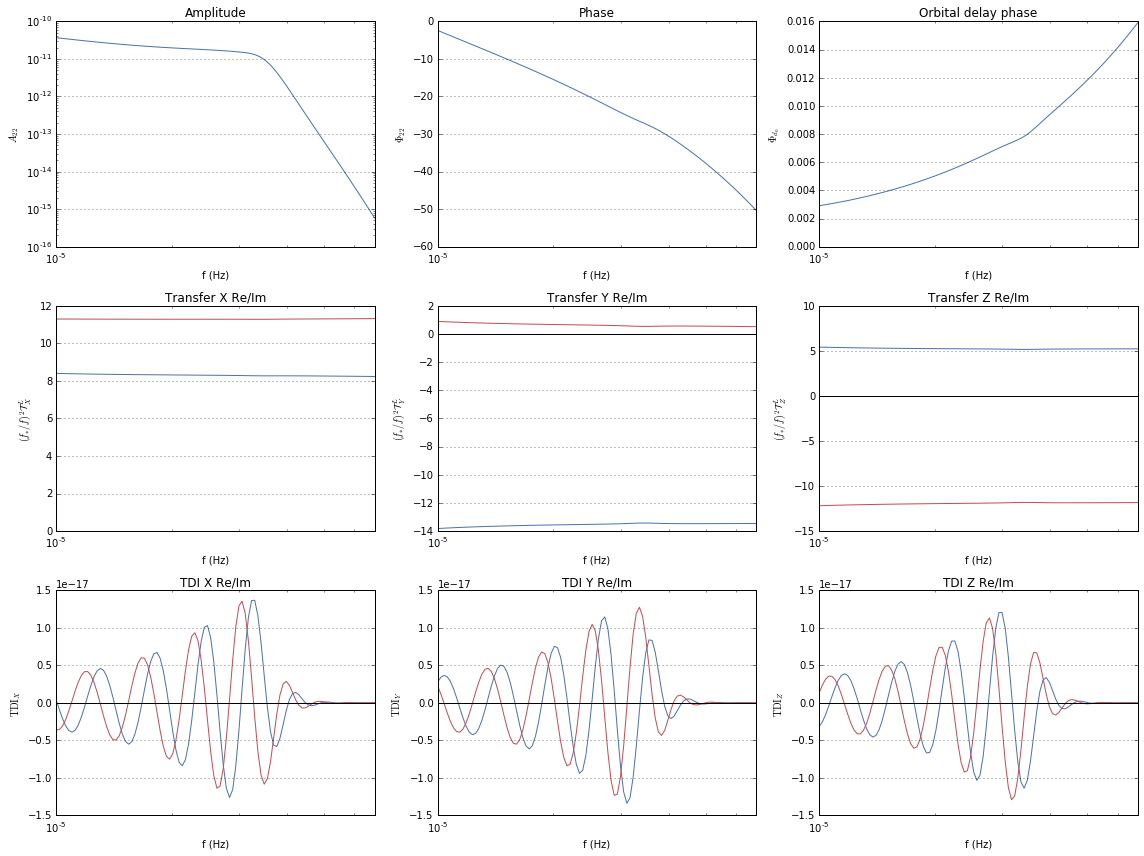

In [30]:
plot_wf_tdi_all(wf_tdi, scalebyf2=True)

### [m1,m2] = [2e6, 1e6] Msol

In [31]:
[m1, m2] = [2e6, 1e6]

In [32]:
wf = GenerateResamplePhenomD(phi0, fRef, m1, m2, chi1, chi2, dist, inc, tobs, minf, maxf)

In [33]:
wf_tdi = LISAFDresponseTDI(wf, inc, lambd, beta, psi, t0=t0, trajdict=trajdict, TDItag=TDItag)

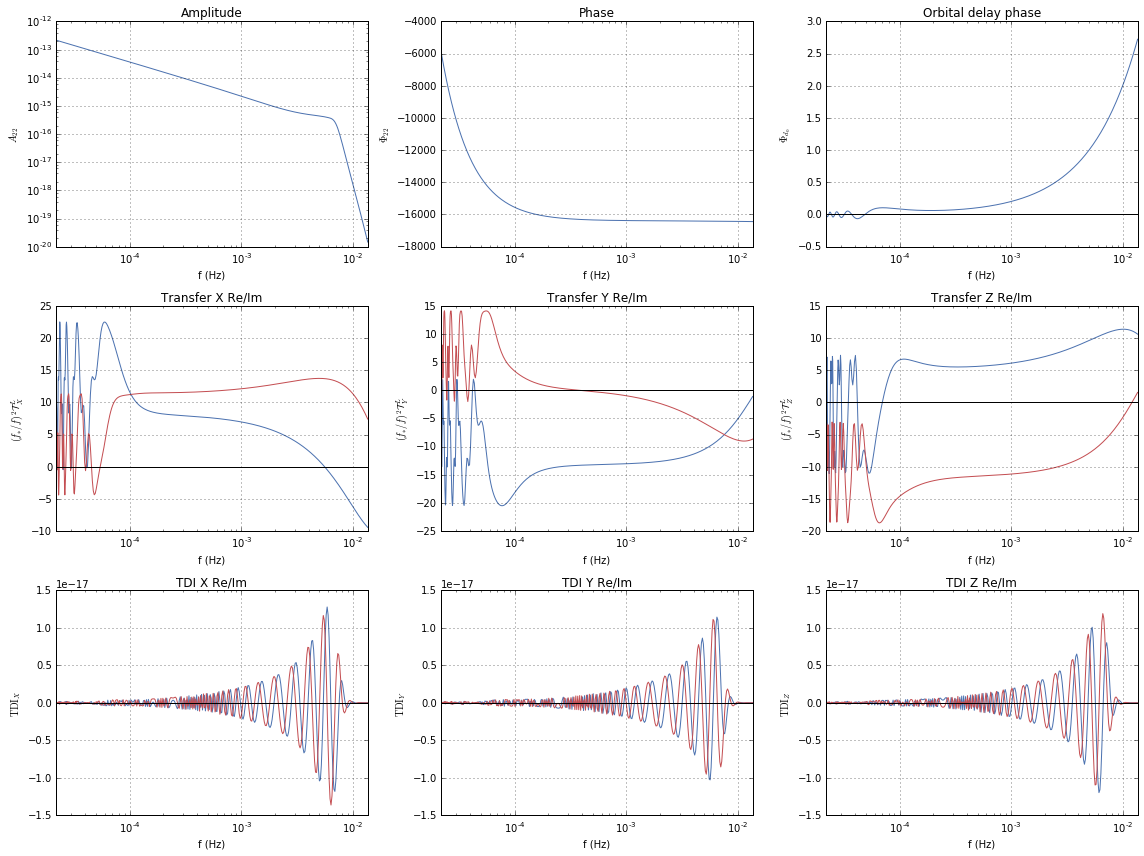

In [34]:
plot_wf_tdi_all(wf_tdi, scalebyf2=True)

### [m1,m2] = [1e4, 5e3] Msol

In [35]:
[m1, m2] = [1e4, 5e3]

In [36]:
wf = GenerateResamplePhenomD(phi0, fRef, m1, m2, chi1, chi2, dist, inc, tobs, minf, maxf)

In [37]:
wf_tdi = LISAFDresponseTDI(wf, inc, lambd, beta, psi, t0=t0, trajdict=trajdict, TDItag=TDItag)

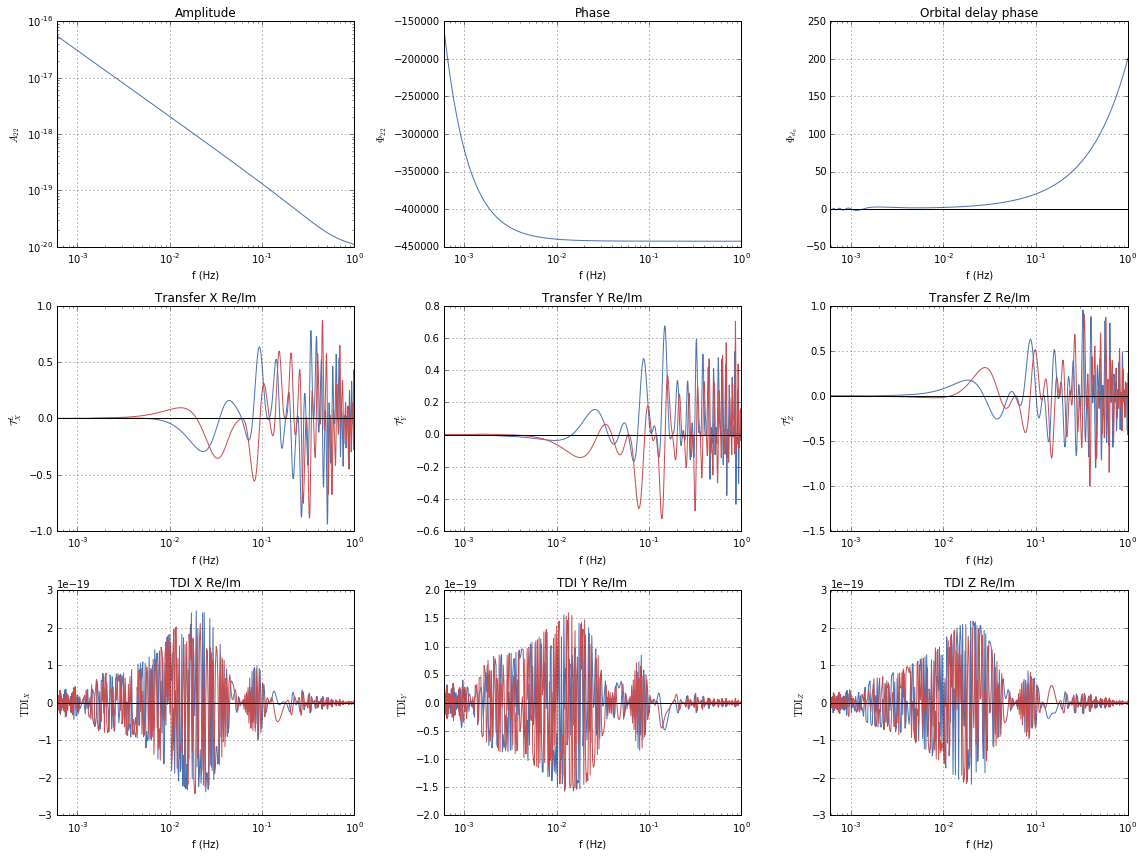

In [38]:
plot_wf_tdi_all(wf_tdi, scalebyf2=False)

### [m1,m2] = [40, 20] Msol

In [39]:
[m1, m2] = [40, 20]

In [40]:
wf = GenerateResamplePhenomD(phi0, fRef, m1, m2, chi1, chi2, dist, inc, tobs, minf, maxf)

In [41]:
wf_tdi = LISAFDresponseTDI(wf, inc, lambd, beta, psi, t0=t0, trajdict=trajdict, TDItag=TDItag)

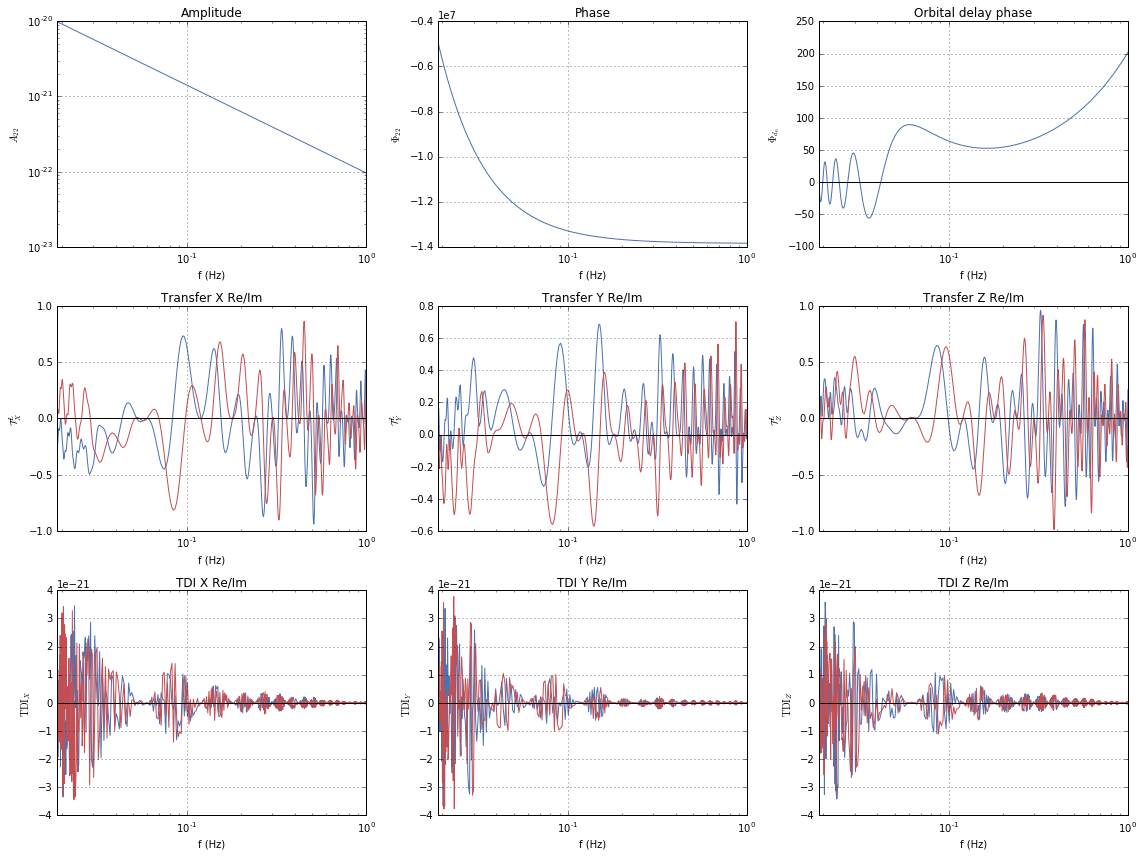

In [42]:
plot_wf_tdi_all(wf_tdi, scalebyf2=False)

## SNR computation: example 

### Loading and definitions

In [11]:
# Temporary path addition - to be changed later
sys.path.append('../../../Packages/common/')
import tdi

In [24]:
# BEWARE: For now, assume input TDI wf has 3 channels AET
# Returns the array of the total SNR, followed by those of the three channels A,E,T 
def LISAComputeSNR_TDIAET(wfTDI, df=None):
    if not wfTDI['TDItag']=='TDIAET':
        raise ValueError('TDItag not supported, must be TDIAET.')
    # If df is not specified, determine it from the Nyquist time, with duration of the signal estimated from tf at the beginning and end of the waveform
    if df is None:
        phasespline = spline(wfTDI['freq'], wfTDI['phase'])
        tfstart = 1./(2*pi) * phasespline(wfTDI['freq'][0], 1)
        tfend = 1./(2*pi) * phasespline(wfTDI['freq'][-1], 1)
        dfval = 0.8 * 1./(2*np.abs(tfend - tfstart)) # Factor 0.8 arbitrary, safety margin in the Nyquist criterion
    else:
        dfval = df
    freqs = np.arange(wfTDI['freq'][0], wfTDI['freq'][-1] + dfval, step=dfval)
    # Compute noise
    Sn_AE = tdi.noisepsd_AE(freqs, model='Proposal', includewd=None)
    Sn_T = tdi.noisepsd_T(freqs, model='Proposal') # Note: here includewd is not implemented
    # Evaluate TDI channels on the array of frequencies
    tdiA_vals = LISAEvaluateTDIFreqGrid(freqs, wfTDI, chan=1)
    tdiE_vals = LISAEvaluateTDIFreqGrid(freqs, wfTDI, chan=2)
    tdiT_vals = LISAEvaluateTDIFreqGrid(freqs, wfTDI, chan=3)
    # Compute SNR
    SNR2_A = 4.*dfval * np.sum(np.abs(tdiA_vals)**2/Sn_AE)
    SNR2_E = 4.*dfval * np.sum(np.abs(tdiE_vals)**2/Sn_AE)
    SNR2_T = 4.*dfval * np.sum(np.abs(tdiT_vals)**2/Sn_T)
    # Result
    return np.array([np.sqrt(SNR2_A + SNR2_E + SNR2_T), np.sqrt(SNR2_A), np.sqrt(SNR2_E), np.sqrt(SNR2_T)])

### [m1,m2] = [2e6,1e6] Msol

In [13]:
# Some generic values for the orientation parameters - 36.6Gpc is z~4
[phi0, fRef, chi1, chi2, dist, inc, lambd, beta, psi] = [1.2, 0., 0.9, -0.8, 36.6e3, pi/3, 1.7, 1.05, 2.3]
# So far, the only choice implemented: MLDC trajectories and TDI XYZ
[t0, trajdict, TDItag] = [0., trajdict_MLDC, 'TDIAET']
# 4 years of observations, frequency band from 1e-5Hz to 1Hz
[minf, maxf, tobs] = [1e-5, 1., 4.]
# Masses
[m1, m2] = [2e6, 1e6]

In [20]:
wf_tdi = LISAGenerateTDI(phi0, fRef, m1, m2, chi1, chi2, dist, inc, lambd, beta, psi, tobs=1., minf=1e-5, maxf=1., t0=0., settRefAtfRef=False, tRef=0., trajdict=trajdict_MLDC, TDItag=TDItag, order_fresnel_stencil=0)

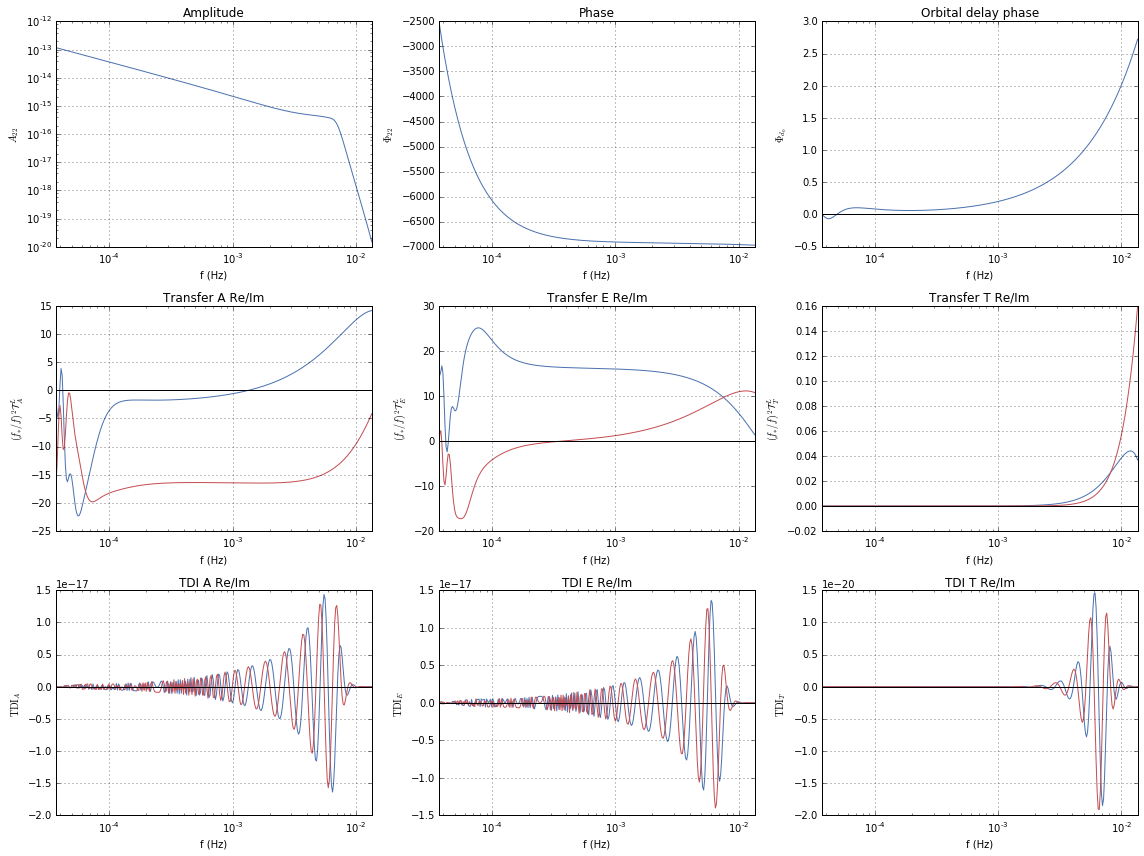

In [15]:
plot_wf_tdi_all(wf_tdi, scalebyf2=True)

In [21]:
LISAComputeSNR_TDIAET(wf_tdi)

array([1401.45882106, 1039.91310548,  939.49329191,    4.46258088])